# long-short-portfolio

On the first trading day of every month, rebalance portfolio to given percentages.  One of the positions is a short position.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import pinkfish as pf

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots.
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Define Portfolios

Note: By using an underscore, we can use a symbol multiple times in a portfolio under a different name.  This is useful when you want to have a short and long position at the same time.

In [3]:
portfolio_option = {'SPY': 0.50, 'TLT': 0.30, 'GLD': 0.10, 'TLT_SHRT': 0.10}

directions = {'SPY': pf.Direction.LONG, 'TLT': pf.Direction.LONG,
              'GLD': pf.Direction.LONG, 'TLT_SHRT' : pf.Direction.SHORT}

Some global data

In [4]:
symbols = list(portfolio_option.keys())
capital = 10000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

In [5]:
options = {
    'use_adj' : True,
    'use_cache' : True,
}
options

{'use_adj': True, 'use_cache': True}

In [6]:
# Fetch timeseries
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, fields=['close'],
                                use_cache=options['use_cache'], use_adj=options['use_adj'])
# Add calendar columns
ts = portfolio.calendar(ts)

# Finalize timeseries
ts, start = portfolio.finalize_timeseries(ts, start)

# Init trade logs
portfolio.init_trade_logs(ts)

In [7]:
pf.TradeLog.cash = capital

# Trading algorithm
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)
    
    # Rebalance on the first trading day of each month
    if row.first_dotm or end_flag:

        #portfolio.print_holdings(date, row)
        
        # If last row, then zero out all weights.  Otherwise use portfolio_option weights.
        weights = portfolio_option if not end_flag else pf.set_dict_values(portfolio_option, 0)

        # Get closing prices for all symbols
        p = portfolio.get_prices(row, fields=['close'])
        prices = {symbol:p[symbol]['close'] for symbol in portfolio.symbols}
        
        # Adjust weights of all symbols in portfolio
        portfolio.adjust_percents(date, prices, weights, row, directions)

    # Record daily balance.
    portfolio.record_daily_balance(date, row)

In [8]:
# Get logs
rlog, tlog, dbal = portfolio.get_logs()

In [9]:
rlog.head(10)

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2004-12-01,0,45.38,22,entry,LONG,GLD
1,2004-12-01,1,83.74,59,entry,LONG,SPY
2,2004-12-01,2,49.20,20,entry,SHRT,TLT_SHRT
3,2004-12-01,3,49.20,60,entry,LONG,TLT
4,2005-01-03,4,50.70,1,exit,LONG,TLT
5,2005-01-03,5,50.70,1,exit,SHRT,TLT_SHRT
6,2005-01-03,6,43.02,1,entry,LONG,GLD
7,2005-02-01,7,52.31,2,exit,LONG,TLT
8,2005-03-01,8,51.61,2,entry,LONG,TLT
9,2005-04-01,9,83.19,1,entry,LONG,SPY


In [10]:
tlog.tail(100)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
357,2017-03-01,105.51,2022-07-01,114.26,-8.75,-8.75,1,21193.46,SHRT,TLT_SHRT
358,2017-03-01,105.51,2022-12-29,100.68,-4.83,-9.65,2,21183.81,LONG,TLT
359,2017-04-03,212.87,2022-12-29,383.44,170.57,170.57,1,21354.38,LONG,SPY
360,2017-05-01,107.38,2022-12-29,100.68,6.70,6.70,1,21361.08,SHRT,TLT_SHRT
361,2017-05-01,107.38,2022-12-29,100.68,-6.70,-6.70,1,21354.38,LONG,TLT
...,...,...,...,...,...,...,...,...,...,...
452,2022-06-01,114.43,2022-12-29,100.68,13.75,13.75,1,22599.98,SHRT,TLT_SHRT
453,2022-08-01,165.03,2022-12-29,168.85,3.82,3.82,1,22603.80,LONG,GLD
454,2022-09-01,108.55,2022-12-29,100.68,-7.87,-31.48,4,22572.32,LONG,TLT
455,2022-11-01,96.31,2022-12-29,100.68,4.37,30.61,7,22602.93,LONG,TLT


In [11]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2022-12-22,35936.71,35936.71,35936.71,203,33.22,1.00,-
2022-12-23,35934.80,35934.80,35934.80,203,33.22,1.00,-
2022-12-27,35749.00,35749.00,35749.00,203,33.22,1.00,-
2022-12-28,35476.67,35476.67,35476.67,203,33.22,1.00,-
2022-12-29,32607.76,32607.76,32607.76,0,32607.76,1.00,X


In [12]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                   2004-11-18
end                                                     2022-12-29
beginning_balance                                            10000
ending_balance                                            32607.76
total_net_profit                                          22607.76
gross_profit                                              27995.17
gross_loss                                                -5387.41
profit_factor                                                 5.20
return_on_initial_capital                                   226.08
annual_return_rate                                            6.74
trading_period                           18 years 1 months 11 days
pct_time_in_market                                           99.82
margin                                                           1
avg_leverage                                                  1.00
max_leverage                                                  

,cumul_total,weight,pct_cumul_total,relative_performance
GLD,"$2,374.39",0.10,0.11,1.05
SPY,"$18,509.63",0.50,0.82,1.64
TLT_SHRT,-$795.56,0.10,-0.04,-0.35
TLT,"$2,519.29",0.30,0.11,0.37
TOTAL,"$22,607.76",1.00,1.00,1.00


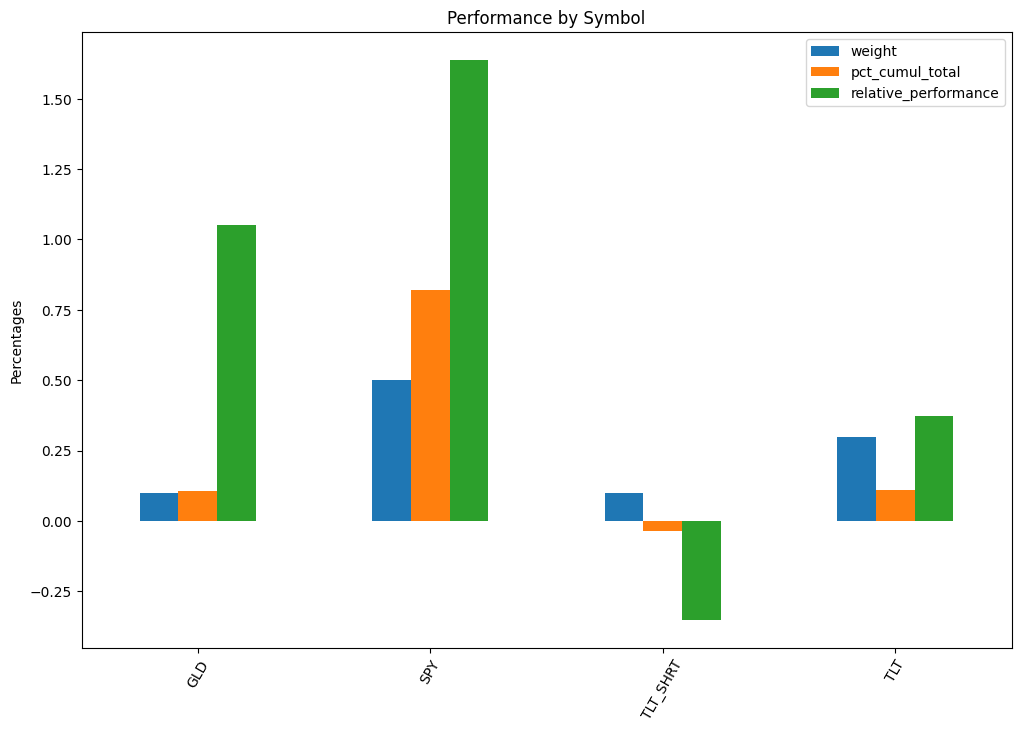

In [13]:
totals = portfolio.performance_per_symbol(portfolio_option)
totals

In [14]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

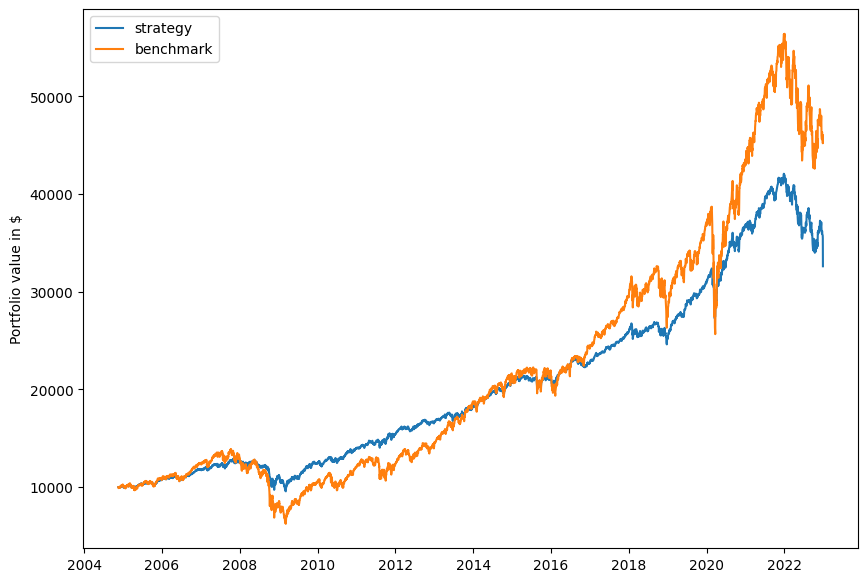

In [15]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

In [16]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$32,607.76","$46,017.35"
total_net_profit,"$22,607.76","$36,017.35"
gross_profit,"$27,995.17","$36,017.35"
gross_loss,"-$5,387.41",$0.00


,strategy,benchmark
annual_return_rate,6.74,8.79
max_closed_out_drawdown,-25.56,-55.03
annualized_return_over_max_drawdown,0.26,0.16
best_month,14.09,23.60
worst_month,-15.78,-30.98
sharpe_ratio,0.75,0.53
sortino_ratio,0.91,0.64
monthly_std,2.36,4.59
annual_std,8.32,16.50


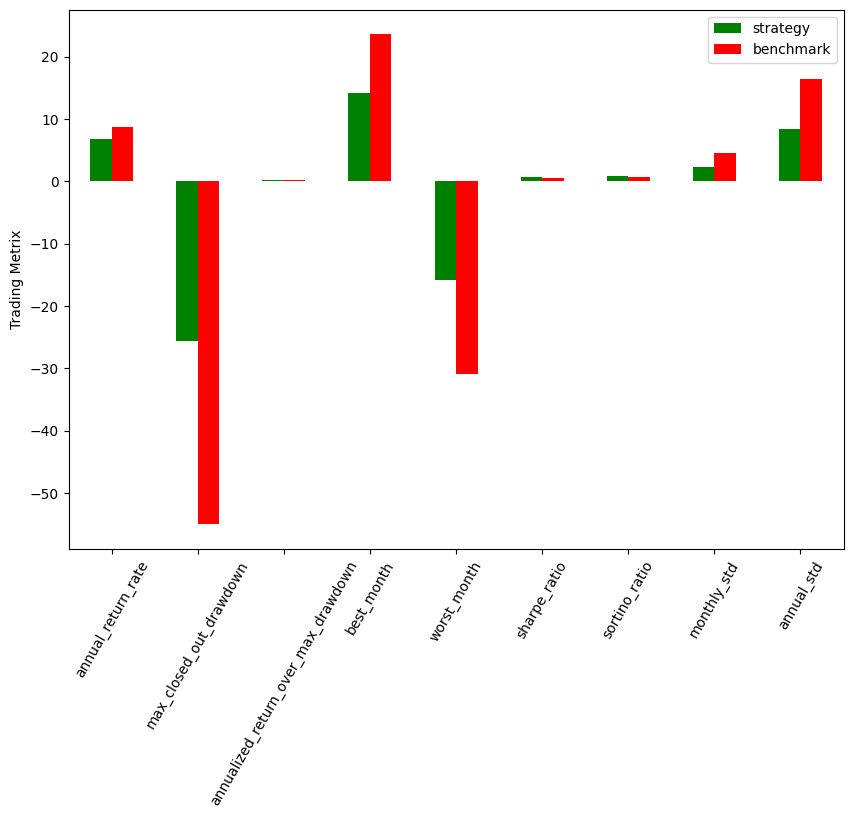

In [17]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df